# Notebook2: Predicting CO2 emissions using Neural Networks

Readme: In this notebook, NN models are constructed for CO2 Emission prediction, and the best model is selected and K-means validation is applied.

- **Notebook content**:
    - Design the architecture of NN and explore different model configuration

    - Tune hyperparameters and select the best model

- **Notebook Output**:

    - Best model file

    - The validation and test results of the best model

In [28]:
# %pip install "numpy<2" torch torchvision scikit-learn
# %pip install wandb

In [29]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## 1 Define Functions

In [30]:
# Define functions
import seaborn as sns
import torch

# 1 plot related functions----------------
# plot predict and true values on validation dataset
def plot_pred_true(y_test, y_pred, ax):

    data = pd.DataFrame({'y_obs': y_test, 'y_pred': y_pred})

    # plt.figure(figsize=(5, 5))
    sns.scatterplot(data=data, x='y_obs', y='y_pred', s=10, ax=ax)
    ax.plot(y_test, y_test, color='red', label='y=x')          # plot the line y=x
    ax.set_title('Observed vs Predicted values in Test Dataset')   # title
    ax.set_xlabel('Observed values')       # label for the x-axis
    ax.set_ylabel('Predicted values')      # label for the y-axis
    ax.legend()
    ax.grid(True)

# plot the loss value on training and validation dataset
def plot_train_val_loss(train_loss, val_loss, ax):
    
    # ax.figure(figsize=(5, 5))

    ax.plot(train_loss, label='train loss')
    ax.plot(val_loss, label='val loss')
    ax.set_title('Train vs Validation Loss')
    ax.set_xlabel('Epoch')
    ax.set_ylabel('Loss')
    ax.legend()
    ax.grid(True)

# 2 Other functions---------------------
# get the prediction and true values
def model_prediction(model, val_loader, device):

    model.eval()
    pred = []
    target = []

    with torch.no_grad():
        for X, y in val_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)      # predicted value

            pred.extend(y_pred.cpu().numpy())
            target.extend(y.cpu().numpy())

    # Merge all the predictions and targets
    predictions = np.concatenate(pred, axis=0)
    labels = np.concatenate(target, axis=0)
    return predictions, labels

## 2 Data Preparation

In [31]:
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

### Load and Divide Traning and Testing Data

Load the test and train dataset

In [32]:
# Import data
trainset_df = pd.read_csv('Dataset2_train.csv').dropna()
testset_df = pd.read_csv('Dataset2_test.csv').dropna()


In [33]:
trainset_df

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Energy Consumption per Distance MJ/100km,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,...,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z,CO2 Emissions(g/km),Make
0,4.0,6.0,1.0,5.000000,434.34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,299.0,NISSAN
1,2.4,4.0,1.0,6.000000,287.28,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,193.0,HYUNDAI
2,2.0,4.0,1.0,8.000000,321.48,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,221.0,BMW
3,2.5,4.0,1.0,6.000000,307.80,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,212.0,TOYOTA
4,5.0,8.0,1.0,8.000000,454.86,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,313.0,JAGUAR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4.0,1.0,6.000000,287.28,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,197.0,MINI
5903,5.6,8.0,1.0,7.000000,526.68,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,362.0,NISSAN
5904,3.5,6.0,1.0,6.000000,283.86,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,193.0,TOYOTA
5905,2.5,4.0,1.0,6.854093,294.12,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,198.0,NISSAN


In [34]:
X_train = trainset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_train = trainset_df['CO2 Emissions(g/km)']

X_test = testset_df.drop(columns=['CO2 Emissions(g/km)', 'Make'])
y_test = testset_df['CO2 Emissions(g/km)']

In [35]:
X_train

,Engine Size(L),Cylinders,Gearbox_Type,Gearbox_Number,Energy Consumption per Distance MJ/100km,Model Features_Flexible-fuel vehicle,Model Features_Four-wheel drive,Model Features_Long wheelbase,Model Features_Short wheelbase,Vehicle Class_FULL-SIZE,...,Vehicle Class_STATION WAGON - SMALL,Vehicle Class_SUBCOMPACT,Vehicle Class_SUV - SMALL,Vehicle Class_SUV - STANDARD,Vehicle Class_TWO-SEATER,Vehicle Class_VAN - CARGO,Vehicle Class_VAN - PASSENGER,Fuel Type_E,Fuel Type_X,Fuel Type_Z
0,4.0,6.0,1.0,5.000000,434.34,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2.4,4.0,1.0,6.000000,287.28,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2.0,4.0,1.0,8.000000,321.48,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,2.5,4.0,1.0,6.000000,307.80,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5.0,8.0,1.0,8.000000,454.86,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5902,2.0,4.0,1.0,6.000000,287.28,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5903,5.6,8.0,1.0,7.000000,526.68,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5904,3.5,6.0,1.0,6.000000,283.86,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
5905,2.5,4.0,1.0,6.854093,294.12,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


### Setup pipline for Standardisation

In [36]:
binary_columns = X_train.columns[X_train.nunique() == 2].tolist()  
numerical_columns = [col for col in X_train.columns if col not in binary_columns]

# ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns)  # StandardScale
    ], 
    remainder='passthrough'  # keep dummy variable
)

# Setup pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

In [37]:
X_train_processed = pipeline.fit_transform(X_train)
X_test_processed = pipeline.transform(X_test)

Inspect the processed data

In [38]:
feature_names = list(X_train) 
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names)

X_test_df = pd.DataFrame(X_test_processed, columns=feature_names)

print("Processed Train Dataset：")
print(X_train_df.head())

print("Processed Test Dataset：")
print(X_test_df.head())


Processed Train Dataset：
   Engine Size(L)  Cylinders  Gearbox_Type  Gearbox_Number  \
0        0.612690   0.200638     -1.602571        0.771485   
1       -0.567895  -0.889172     -0.750938       -0.943120   
2       -0.863042  -0.889172      0.952329       -0.544375   
3       -0.494109  -0.889172     -0.750938       -0.703873   
4        1.350555   1.290448      0.952329        1.010732   

   Energy Consumption per Distance MJ/100km  \
0                                       1.0   
1                                       1.0   
2                                       1.0   
3                                       1.0   
4                                       1.0   

   Model Features_Flexible-fuel vehicle  Model Features_Four-wheel drive  \
0                                   0.0                              0.0   
1                                   0.0                              0.0   
2                                   0.0                              0.0   
3              

In [39]:
# Prepare the Dataloader
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Convert data to Tensor
X_train_tensor = torch.tensor(X_train_processed, dtype=torch.float32) 
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

X_val_tensor = torch.tensor(X_test_processed, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Load the training data and validation data
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_val_tensor,y_test_tensor)

# Set hyperparameters
batch_size = 64  # batch size

# Create data loader
train_Loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_Loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)



## 3 Best Models

#### Pre: k-fold Import K-fold Cross-validation Method

In [40]:
from sklearn.model_selection import KFold

k_fold = KFold(n_splits=20, shuffle=True, random_state=42) # Set randon seed to make sure the results are reproducible

Import metrics

In [41]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error

### 3.1 Neural Network Model

#### 3.1.1 Use W&B Grid Search to Find Best NN Parameter Set

In [42]:
import wandb

wandb.login(key="47ea61c7ee69e2e0e1cc46ed5c31bd6168f9f9db")

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\87383\_netrc


True

Neural Network Structure

In [43]:
class MultiLayerPerceptron(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MultiLayerPerceptron, self).__init__()

        # Initialise an empty list to hold layers
        layers = []

        # First layer: input to hidden
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())

        # Additional hidden layers
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            
        # Output layer: hidden to output
        layers.append(nn.Linear(hidden_size, output_size))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

In [44]:
from torch.utils.data import random_split

# Calculate the sizes for train and validation splits
num_total = len(train_dataset)
num_train = int(0.9 * num_total)
num_val = num_total - num_train

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [num_train, num_val])

# Create DataLoaders for each subset
train_Loader = DataLoader(train_subset, batch_size=64, shuffle=True)
val_Loader = DataLoader(val_subset, batch_size=64, shuffle=False)

In [45]:
# Hyperparameter grid
hidden_units_options = [32, 64, 128]    # Numbers of neurons in each hidden layer
hidden_layers_options = [2, 3, 4]       # Numbers of hidden layers
learning_rates = [0.1, 0.01, 0.001]     # Learning rates

max_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

learning_rate = 0.02        # Learning rate
n_epochs = 100 # Numebr of epochs

# Define the loss function and the optimizer
criterion = nn.MSELoss()    # Mean Squared Error for Linear Regression


In [46]:
# Define helper functions
# Train epoch function
def train_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0

    # for features, target in tqdm(train_loader, desc=f"Training Epoch {epoch+1}"):
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()
        outputs = model(features) # Forward pass
        loss = criterion(outputs, target)

        loss.backward()  # Backward pass
        optimizer.step() # Update the weights

        running_loss += loss.item() * features.size(0)

    return running_loss / len(train_loader.dataset)

# Validation epoch function
def val_epoch(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for features, target in val_loader:
            # print(featuresfeatures.size(0))
            features, target = features.to(device), target.to(device)
            # features = features.view(features.size(0), -1)

            outputs = model(features)
            loss = criterion(outputs, target)
            val_loss += loss.item() * features.size(0)

    return val_loss / len(val_loader.dataset)



In [47]:
from itertools import product
import torch.optim as optim

for hidden_units, hidden_layers, lr in product(hidden_units_options, hidden_layers_options, learning_rates):

    # Configurations
    config = {
        "hidden_units": hidden_units,
        "hidden_layers": hidden_layers,
        "learning_rate": lr,
        "max_epochs": max_epochs,
        "patience": patience
    }

    # Start a new W&B run for each configuration
    wandb.init(project='DE_Groupwork_G4_stage1', config=config, reinit=True)

    model = MultiLayerPerceptron(input_size=input_size, 
                             hidden_size=config["hidden_units"], 
                             num_layers=config["hidden_layers"], 
                             output_size=1).to(device)


    criterion = nn.MSELoss() 
    optimizer = optim.Adam(model.parameters(), lr=lr)

    best_test_loss = float('inf')
    epochs_without_improvement = 0
        
    for epoch in range(1, max_epochs + 1):
        train_loss = train_epoch(model, train_Loader, criterion, optimizer, device)
       
        test_loss = val_epoch(model, test_Loader, criterion, device)

        # Log metrics to W&B
        wandb.log({"epoch": epoch, "train_loss": train_loss, "val_loss": test_loss})
        
        print(f"Epoch {epoch:03d} | Train Loss: {train_loss:.4f} | Val Loss: {test_loss:.4f}")
        
        # Early stopping check
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch}")
            break

    wandb.finish()

print("Training complete for all configurations.")


Epoch 001 | Train Loss: 5684.9589 | Val Loss: 432.9472
Epoch 002 | Train Loss: 227.0380 | Val Loss: 159.9093
Epoch 003 | Train Loss: 97.2622 | Val Loss: 71.7838
Epoch 004 | Train Loss: 40.0519 | Val Loss: 31.7289
Epoch 005 | Train Loss: 20.9705 | Val Loss: 18.8927
Epoch 006 | Train Loss: 17.4531 | Val Loss: 37.1671
Epoch 007 | Train Loss: 45.2787 | Val Loss: 46.3617
Epoch 008 | Train Loss: 25.7191 | Val Loss: 56.5196
Epoch 009 | Train Loss: 20.3182 | Val Loss: 35.1532
Epoch 010 | Train Loss: 22.6486 | Val Loss: 14.8951
Epoch 011 | Train Loss: 15.5698 | Val Loss: 26.7951
Epoch 012 | Train Loss: 17.1965 | Val Loss: 47.7210
Epoch 013 | Train Loss: 41.4849 | Val Loss: 99.7631
Epoch 014 | Train Loss: 40.4423 | Val Loss: 20.5432
Epoch 015 | Train Loss: 26.2336 | Val Loss: 25.3169
Early stopping triggered at epoch 15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▂▂▁▁▁▂▂▁▁
epoch,15
train_loss,26.23361
val_loss,25.31687


Epoch 001 | Train Loss: 26068.8764 | Val Loss: 1128.9832
Epoch 002 | Train Loss: 814.8440 | Val Loss: 659.8560
Epoch 003 | Train Loss: 519.4361 | Val Loss: 458.0310
Epoch 004 | Train Loss: 367.9968 | Val Loss: 339.3757
Epoch 005 | Train Loss: 271.5075 | Val Loss: 259.8137
Epoch 006 | Train Loss: 210.2598 | Val Loss: 212.1234
Epoch 007 | Train Loss: 170.2192 | Val Loss: 171.7975
Epoch 008 | Train Loss: 138.4198 | Val Loss: 139.6888
Epoch 009 | Train Loss: 109.2448 | Val Loss: 110.2083
Epoch 010 | Train Loss: 84.4231 | Val Loss: 84.1718
Epoch 011 | Train Loss: 62.2225 | Val Loss: 59.9747
Epoch 012 | Train Loss: 44.3123 | Val Loss: 43.5192
Epoch 013 | Train Loss: 31.7182 | Val Loss: 31.6957
Epoch 014 | Train Loss: 23.1151 | Val Loss: 26.9741
Epoch 015 | Train Loss: 17.1547 | Val Loss: 16.6460
Epoch 016 | Train Loss: 13.4483 | Val Loss: 15.4543
Epoch 017 | Train Loss: 11.6333 | Val Loss: 13.0735
Epoch 018 | Train Loss: 11.2771 | Val Loss: 12.0606
Epoch 019 | Train Loss: 10.3405 | Val Loss:

epoch,▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,37
train_loss,10.01897
val_loss,9.90947


Epoch 001 | Train Loss: 65576.9718 | Val Loss: 62728.3097
Epoch 002 | Train Loss: 55512.4145 | Val Loss: 41811.6966
Epoch 003 | Train Loss: 24698.7824 | Val Loss: 8732.1925
Epoch 004 | Train Loss: 3720.6282 | Val Loss: 1948.1775
Epoch 005 | Train Loss: 1638.8725 | Val Loss: 1460.2546
Epoch 006 | Train Loss: 1273.9440 | Val Loss: 1182.4016
Epoch 007 | Train Loss: 1042.9137 | Val Loss: 993.3123
Epoch 008 | Train Loss: 885.9123 | Val Loss: 860.1931
Epoch 009 | Train Loss: 768.8070 | Val Loss: 760.1403
Epoch 010 | Train Loss: 678.5078 | Val Loss: 678.1964
Epoch 011 | Train Loss: 603.7776 | Val Loss: 609.0133
Epoch 012 | Train Loss: 541.6039 | Val Loss: 554.9296
Epoch 013 | Train Loss: 491.6415 | Val Loss: 508.1561
Epoch 014 | Train Loss: 449.5603 | Val Loss: 467.8793
Epoch 015 | Train Loss: 414.3058 | Val Loss: 434.5980
Epoch 016 | Train Loss: 382.9814 | Val Loss: 408.1806
Epoch 017 | Train Loss: 357.4150 | Val Loss: 382.0040
Epoch 018 | Train Loss: 334.4183 | Val Loss: 359.2484
Epoch 019 

epoch,▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,114
train_loss,8.4938
val_loss,9.09779


Epoch 001 | Train Loss: 4295.6183 | Val Loss: 271.7341
Epoch 002 | Train Loss: 181.5026 | Val Loss: 143.2667
Epoch 003 | Train Loss: 82.1883 | Val Loss: 51.1509
Epoch 004 | Train Loss: 38.8854 | Val Loss: 25.4730
Epoch 005 | Train Loss: 29.6722 | Val Loss: 29.6445
Epoch 006 | Train Loss: 53.5422 | Val Loss: 86.7614
Epoch 007 | Train Loss: 63.3367 | Val Loss: 2162.7078
Epoch 008 | Train Loss: 1324.3004 | Val Loss: 37.4312
Epoch 009 | Train Loss: 15.6728 | Val Loss: 13.4048
Epoch 010 | Train Loss: 13.2499 | Val Loss: 14.0461
Epoch 011 | Train Loss: 13.1815 | Val Loss: 14.5213
Epoch 012 | Train Loss: 12.1622 | Val Loss: 13.0980
Epoch 013 | Train Loss: 14.8974 | Val Loss: 13.8936
Epoch 014 | Train Loss: 10.7164 | Val Loss: 17.8415
Epoch 015 | Train Loss: 17.6889 | Val Loss: 14.8234
Epoch 016 | Train Loss: 13.0130 | Val Loss: 11.8546
Epoch 017 | Train Loss: 15.5684 | Val Loss: 30.6732
Epoch 018 | Train Loss: 16.8607 | Val Loss: 19.2989
Epoch 019 | Train Loss: 12.8636 | Val Loss: 22.9074
Epo

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▃▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
train_loss,13.21163
val_loss,32.43015


Epoch 001 | Train Loss: 20279.8204 | Val Loss: 722.4582
Epoch 002 | Train Loss: 487.7913 | Val Loss: 367.4550
Epoch 003 | Train Loss: 251.4566 | Val Loss: 196.6059
Epoch 004 | Train Loss: 126.0732 | Val Loss: 91.5757
Epoch 005 | Train Loss: 53.2550 | Val Loss: 34.6878
Epoch 006 | Train Loss: 23.7934 | Val Loss: 20.8677
Epoch 007 | Train Loss: 15.9955 | Val Loss: 16.4916
Epoch 008 | Train Loss: 13.6044 | Val Loss: 14.4082
Epoch 009 | Train Loss: 11.5736 | Val Loss: 14.4514
Epoch 010 | Train Loss: 12.5525 | Val Loss: 12.1480
Epoch 011 | Train Loss: 11.1949 | Val Loss: 13.7477
Epoch 012 | Train Loss: 11.7107 | Val Loss: 11.6691
Epoch 013 | Train Loss: 10.8469 | Val Loss: 10.5330
Epoch 014 | Train Loss: 10.5973 | Val Loss: 10.7159
Epoch 015 | Train Loss: 10.4209 | Val Loss: 22.2321
Epoch 016 | Train Loss: 11.0919 | Val Loss: 15.0724
Epoch 017 | Train Loss: 10.8996 | Val Loss: 23.0034
Epoch 018 | Train Loss: 10.5003 | Val Loss: 9.9176
Epoch 019 | Train Loss: 9.9874 | Val Loss: 12.4416
Epoch

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,23
train_loss,10.33166
val_loss,11.28811


Epoch 001 | Train Loss: 64306.3498 | Val Loss: 54912.4839
Epoch 002 | Train Loss: 21332.2009 | Val Loss: 1983.4479
Epoch 003 | Train Loss: 1458.8974 | Val Loss: 1140.3168
Epoch 004 | Train Loss: 927.2481 | Val Loss: 824.3544
Epoch 005 | Train Loss: 696.1938 | Val Loss: 658.4606
Epoch 006 | Train Loss: 556.0088 | Val Loss: 546.7618
Epoch 007 | Train Loss: 460.6027 | Val Loss: 465.5658
Epoch 008 | Train Loss: 394.3031 | Val Loss: 412.5969
Epoch 009 | Train Loss: 343.4101 | Val Loss: 359.0078
Epoch 010 | Train Loss: 299.9994 | Val Loss: 317.3631
Epoch 011 | Train Loss: 265.6060 | Val Loss: 283.9456
Epoch 012 | Train Loss: 235.5904 | Val Loss: 253.3727
Epoch 013 | Train Loss: 210.1204 | Val Loss: 227.2596
Epoch 014 | Train Loss: 187.7790 | Val Loss: 206.8068
Epoch 015 | Train Loss: 169.1779 | Val Loss: 184.2058
Epoch 016 | Train Loss: 153.2483 | Val Loss: 167.4818
Epoch 017 | Train Loss: 139.0274 | Val Loss: 153.5259
Epoch 018 | Train Loss: 126.9647 | Val Loss: 139.2969
Epoch 019 | Train L

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇███
train_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,56
train_loss,9.31515
val_loss,11.33985


Epoch 001 | Train Loss: 5601.5938 | Val Loss: 268.2481
Epoch 002 | Train Loss: 191.7449 | Val Loss: 206.4569
Epoch 003 | Train Loss: 96.3585 | Val Loss: 112.2993
Epoch 004 | Train Loss: 49.7970 | Val Loss: 125.2713
Epoch 005 | Train Loss: 47.1047 | Val Loss: 34.2078
Epoch 006 | Train Loss: 33.1752 | Val Loss: 189.5582
Epoch 007 | Train Loss: 44.2711 | Val Loss: 21.6726
Epoch 008 | Train Loss: 116.6344 | Val Loss: 110.9597
Epoch 009 | Train Loss: 71.8516 | Val Loss: 23.8139
Epoch 010 | Train Loss: 320.9662 | Val Loss: 2115.7022
Epoch 011 | Train Loss: 199.3344 | Val Loss: 22.8893
Epoch 012 | Train Loss: 19.5109 | Val Loss: 29.2978
Early stopping triggered at epoch 12


epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁
val_loss,▂▂▁▁▁▂▁▁▁█▁▁
epoch,12
train_loss,19.51086
val_loss,29.29778


Epoch 001 | Train Loss: 17588.8927 | Val Loss: 667.4967
Epoch 002 | Train Loss: 453.4363 | Val Loss: 383.8189
Epoch 003 | Train Loss: 277.4824 | Val Loss: 239.1008
Epoch 004 | Train Loss: 178.5787 | Val Loss: 163.3355
Epoch 005 | Train Loss: 124.9494 | Val Loss: 136.7734
Epoch 006 | Train Loss: 87.6747 | Val Loss: 84.5271
Epoch 007 | Train Loss: 57.1565 | Val Loss: 52.2982
Epoch 008 | Train Loss: 36.9151 | Val Loss: 35.5532
Epoch 009 | Train Loss: 26.5324 | Val Loss: 29.2467
Epoch 010 | Train Loss: 18.2449 | Val Loss: 16.6761
Epoch 011 | Train Loss: 13.3558 | Val Loss: 14.1585
Epoch 012 | Train Loss: 12.3837 | Val Loss: 14.4308
Epoch 013 | Train Loss: 12.1252 | Val Loss: 10.7948
Epoch 014 | Train Loss: 10.1035 | Val Loss: 12.4716
Epoch 015 | Train Loss: 11.8687 | Val Loss: 12.4799
Epoch 016 | Train Loss: 11.2026 | Val Loss: 9.9119
Epoch 017 | Train Loss: 10.7417 | Val Loss: 13.8019
Epoch 018 | Train Loss: 12.0580 | Val Loss: 12.5308
Epoch 019 | Train Loss: 11.5254 | Val Loss: 10.7822
E

epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,21
train_loss,14.06243
val_loss,16.117


Epoch 001 | Train Loss: 63772.5039 | Val Loss: 49461.4415
Epoch 002 | Train Loss: 11801.2012 | Val Loss: 1369.8855
Epoch 003 | Train Loss: 1076.3710 | Val Loss: 841.3009
Epoch 004 | Train Loss: 718.0974 | Val Loss: 636.3281
Epoch 005 | Train Loss: 547.0719 | Val Loss: 514.0175
Epoch 006 | Train Loss: 445.5437 | Val Loss: 432.4827
Epoch 007 | Train Loss: 371.7794 | Val Loss: 370.1806
Epoch 008 | Train Loss: 314.7434 | Val Loss: 319.2654
Epoch 009 | Train Loss: 270.7148 | Val Loss: 277.4313
Epoch 010 | Train Loss: 232.4131 | Val Loss: 241.7608
Epoch 011 | Train Loss: 201.4410 | Val Loss: 212.4978
Epoch 012 | Train Loss: 176.0741 | Val Loss: 186.9975
Epoch 013 | Train Loss: 153.1820 | Val Loss: 164.0410
Epoch 014 | Train Loss: 134.2261 | Val Loss: 145.1302
Epoch 015 | Train Loss: 118.6029 | Val Loss: 128.0612
Epoch 016 | Train Loss: 105.6780 | Val Loss: 114.6293
Epoch 017 | Train Loss: 92.1165 | Val Loss: 99.8974
Epoch 018 | Train Loss: 80.7879 | Val Loss: 86.8018
Epoch 019 | Train Loss: 

epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,58
train_loss,9.14935
val_loss,10.36388


Epoch 001 | Train Loss: 5367.0339 | Val Loss: 346.1573
Epoch 002 | Train Loss: 213.4262 | Val Loss: 156.2706
Epoch 003 | Train Loss: 95.1106 | Val Loss: 80.4394
Epoch 004 | Train Loss: 48.9886 | Val Loss: 53.4198
Epoch 005 | Train Loss: 32.0221 | Val Loss: 37.2005
Epoch 006 | Train Loss: 20.5775 | Val Loss: 41.3516
Epoch 007 | Train Loss: 32.6572 | Val Loss: 24.0800
Epoch 008 | Train Loss: 17.9034 | Val Loss: 47.0996
Epoch 009 | Train Loss: 20.8619 | Val Loss: 47.6163
Epoch 010 | Train Loss: 19.9855 | Val Loss: 45.9665
Epoch 011 | Train Loss: 44.8849 | Val Loss: 321.9528
Epoch 012 | Train Loss: 156.9628 | Val Loss: 30.9424
Early stopping triggered at epoch 12


epoch,▁▂▂▃▄▄▅▅▆▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▂▂▁▇▁
epoch,12
train_loss,156.96284
val_loss,30.94239


Epoch 001 | Train Loss: 17770.6098 | Val Loss: 881.6893
Epoch 002 | Train Loss: 564.1477 | Val Loss: 391.5139
Epoch 003 | Train Loss: 245.7239 | Val Loss: 193.7192
Epoch 004 | Train Loss: 147.2872 | Val Loss: 140.7518
Epoch 005 | Train Loss: 109.2175 | Val Loss: 111.2636
Epoch 006 | Train Loss: 82.2337 | Val Loss: 84.1766
Epoch 007 | Train Loss: 62.3659 | Val Loss: 63.0341
Epoch 008 | Train Loss: 45.4651 | Val Loss: 49.5748
Epoch 009 | Train Loss: 32.4190 | Val Loss: 32.8602
Epoch 010 | Train Loss: 22.3311 | Val Loss: 20.9996
Epoch 011 | Train Loss: 15.3826 | Val Loss: 18.0510
Epoch 012 | Train Loss: 11.6376 | Val Loss: 13.3004
Epoch 013 | Train Loss: 11.1604 | Val Loss: 10.6053
Epoch 014 | Train Loss: 10.5222 | Val Loss: 13.8182
Epoch 015 | Train Loss: 10.7926 | Val Loss: 10.7086
Epoch 016 | Train Loss: 9.6606 | Val Loss: 10.5752
Epoch 017 | Train Loss: 10.3696 | Val Loss: 9.3397
Epoch 018 | Train Loss: 9.5093 | Val Loss: 9.5888
Epoch 019 | Train Loss: 9.3914 | Val Loss: 10.8612
Epoch

epoch,▁▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▆▇▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,22
train_loss,11.40109
val_loss,10.19504


Epoch 001 | Train Loss: 64072.6642 | Val Loss: 56038.3361
Epoch 002 | Train Loss: 33850.1645 | Val Loss: 8380.4267
Epoch 003 | Train Loss: 2776.7806 | Val Loss: 1567.9720
Epoch 004 | Train Loss: 1327.9901 | Val Loss: 1197.5200
Epoch 005 | Train Loss: 1048.4799 | Val Loss: 993.6215
Epoch 006 | Train Loss: 878.0912 | Val Loss: 858.3244
Epoch 007 | Train Loss: 766.2727 | Val Loss: 758.2129
Epoch 008 | Train Loss: 685.4827 | Val Loss: 692.1457
Epoch 009 | Train Loss: 619.3942 | Val Loss: 627.9913
Epoch 010 | Train Loss: 564.5818 | Val Loss: 574.6131
Epoch 011 | Train Loss: 516.4721 | Val Loss: 533.6092
Epoch 012 | Train Loss: 476.1270 | Val Loss: 491.3686
Epoch 013 | Train Loss: 439.9249 | Val Loss: 458.5085
Epoch 014 | Train Loss: 406.2345 | Val Loss: 425.8267
Epoch 015 | Train Loss: 375.8150 | Val Loss: 396.0359
Epoch 016 | Train Loss: 349.2622 | Val Loss: 370.1260
Epoch 017 | Train Loss: 325.9434 | Val Loss: 348.1144
Epoch 018 | Train Loss: 304.2093 | Val Loss: 327.2303
Epoch 019 | Trai

epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇██
train_loss,█▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,85
train_loss,8.4703
val_loss,8.88359


Epoch 001 | Train Loss: 23209.2925 | Val Loss: 327.7345
Epoch 002 | Train Loss: 177.3181 | Val Loss: 87.9617
Epoch 003 | Train Loss: 62.8053 | Val Loss: 55.5522
Epoch 004 | Train Loss: 40.8645 | Val Loss: 65.8266
Epoch 005 | Train Loss: 31.6286 | Val Loss: 22.0922
Epoch 006 | Train Loss: 24.1179 | Val Loss: 20.8483
Epoch 007 | Train Loss: 25.7577 | Val Loss: 44.7585
Epoch 008 | Train Loss: 17.0221 | Val Loss: 24.4369
Epoch 009 | Train Loss: 27.2246 | Val Loss: 39.5171
Epoch 010 | Train Loss: 26.9798 | Val Loss: 15.9001
Epoch 011 | Train Loss: 24.4974 | Val Loss: 20.2718
Epoch 012 | Train Loss: 15.0915 | Val Loss: 11.6522
Epoch 013 | Train Loss: 13.4629 | Val Loss: 47.7968
Epoch 014 | Train Loss: 32.1661 | Val Loss: 14.9057
Epoch 015 | Train Loss: 20.3240 | Val Loss: 26.0385
Epoch 016 | Train Loss: 15.2420 | Val Loss: 13.1535
Epoch 017 | Train Loss: 13.6203 | Val Loss: 13.0292
Early stopping triggered at epoch 17


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▁▁▂▁▂▁▁▁▂▁▁▁▁
epoch,17
train_loss,13.6203
val_loss,13.02917


Epoch 001 | Train Loss: 12452.4033 | Val Loss: 648.7354
Epoch 002 | Train Loss: 392.8217 | Val Loss: 282.8874
Epoch 003 | Train Loss: 192.6397 | Val Loss: 168.7127
Epoch 004 | Train Loss: 120.3938 | Val Loss: 108.2264
Epoch 005 | Train Loss: 72.2954 | Val Loss: 62.6671
Epoch 006 | Train Loss: 38.2960 | Val Loss: 26.1397
Epoch 007 | Train Loss: 18.8687 | Val Loss: 43.1324
Epoch 008 | Train Loss: 16.3119 | Val Loss: 14.7597
Epoch 009 | Train Loss: 12.6528 | Val Loss: 10.9432
Epoch 010 | Train Loss: 11.1294 | Val Loss: 11.8990
Epoch 011 | Train Loss: 12.9364 | Val Loss: 12.1980
Epoch 012 | Train Loss: 11.3052 | Val Loss: 10.4135
Epoch 013 | Train Loss: 10.2082 | Val Loss: 11.8111
Epoch 014 | Train Loss: 14.0414 | Val Loss: 25.3828
Epoch 015 | Train Loss: 14.5357 | Val Loss: 12.9395
Epoch 016 | Train Loss: 11.4434 | Val Loss: 11.0041
Epoch 017 | Train Loss: 15.0530 | Val Loss: 16.6070
Early stopping triggered at epoch 17


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,17
train_loss,15.053
val_loss,16.60702


Epoch 001 | Train Loss: 57593.1719 | Val Loss: 21019.1942
Epoch 002 | Train Loss: 3516.3086 | Val Loss: 1117.4006
Epoch 003 | Train Loss: 885.9377 | Val Loss: 745.6730
Epoch 004 | Train Loss: 635.4149 | Val Loss: 585.4353
Epoch 005 | Train Loss: 506.2739 | Val Loss: 484.2035
Epoch 006 | Train Loss: 417.9597 | Val Loss: 412.2882
Epoch 007 | Train Loss: 350.8368 | Val Loss: 352.6594
Epoch 008 | Train Loss: 299.5803 | Val Loss: 307.5783
Epoch 009 | Train Loss: 258.6465 | Val Loss: 266.3292
Epoch 010 | Train Loss: 222.0080 | Val Loss: 235.7577
Epoch 011 | Train Loss: 192.6226 | Val Loss: 205.5038
Epoch 012 | Train Loss: 168.1148 | Val Loss: 181.4671
Epoch 013 | Train Loss: 147.2344 | Val Loss: 159.7488
Epoch 014 | Train Loss: 129.7962 | Val Loss: 141.1110
Epoch 015 | Train Loss: 114.4364 | Val Loss: 124.1949
Epoch 016 | Train Loss: 98.6969 | Val Loss: 112.1648
Epoch 017 | Train Loss: 87.4555 | Val Loss: 96.4904
Epoch 018 | Train Loss: 76.1820 | Val Loss: 85.7151
Epoch 019 | Train Loss: 65.

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,56
train_loss,8.69078
val_loss,9.43328


Epoch 001 | Train Loss: 5324.8223 | Val Loss: 314.0550
Epoch 002 | Train Loss: 190.1336 | Val Loss: 91.9837
Epoch 003 | Train Loss: 84.1635 | Val Loss: 101.0192
Epoch 004 | Train Loss: 212.9302 | Val Loss: 508.8862
Epoch 005 | Train Loss: 215.3521 | Val Loss: 19.9742
Epoch 006 | Train Loss: 28.7942 | Val Loss: 119.7837
Epoch 007 | Train Loss: 626.9793 | Val Loss: 506.2651
Epoch 008 | Train Loss: 189.7905 | Val Loss: 24.7084
Epoch 009 | Train Loss: 18.8601 | Val Loss: 31.1361
Epoch 010 | Train Loss: 15.4469 | Val Loss: 15.7467
Epoch 011 | Train Loss: 33.4741 | Val Loss: 12.7756
Epoch 012 | Train Loss: 23.9950 | Val Loss: 27.7649
Epoch 013 | Train Loss: 20.8943 | Val Loss: 16.6221
Epoch 014 | Train Loss: 23.7280 | Val Loss: 56.8748
Epoch 015 | Train Loss: 38.4609 | Val Loss: 28.1741
Epoch 016 | Train Loss: 1530.9791 | Val Loss: 1562.3311
Early stopping triggered at epoch 16


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▂▁▁▁▁▁▁▁▁▃
val_loss,▂▁▁▃▁▁▃▁▁▁▁▁▁▁▁█
epoch,16
train_loss,1530.97906
val_loss,1562.33113


Epoch 001 | Train Loss: 11039.4971 | Val Loss: 460.0582
Epoch 002 | Train Loss: 277.9615 | Val Loss: 206.2116
Epoch 003 | Train Loss: 129.9109 | Val Loss: 124.7597
Epoch 004 | Train Loss: 75.1571 | Val Loss: 66.0882
Epoch 005 | Train Loss: 45.0398 | Val Loss: 39.7234
Epoch 006 | Train Loss: 27.7352 | Val Loss: 23.5057
Epoch 007 | Train Loss: 16.3099 | Val Loss: 26.3645
Epoch 008 | Train Loss: 15.7173 | Val Loss: 21.2576
Epoch 009 | Train Loss: 12.2547 | Val Loss: 11.4101
Epoch 010 | Train Loss: 12.8138 | Val Loss: 26.1883
Epoch 011 | Train Loss: 14.7435 | Val Loss: 10.6170
Epoch 012 | Train Loss: 11.1698 | Val Loss: 25.5292
Epoch 013 | Train Loss: 14.8687 | Val Loss: 16.4916
Epoch 014 | Train Loss: 13.6140 | Val Loss: 13.8669
Epoch 015 | Train Loss: 11.2497 | Val Loss: 11.4731
Epoch 016 | Train Loss: 13.2863 | Val Loss: 40.1406
Early stopping triggered at epoch 16


epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,16
train_loss,13.28633
val_loss,40.14064


Epoch 001 | Train Loss: 53759.1546 | Val Loss: 2438.3561
Epoch 002 | Train Loss: 1774.0786 | Val Loss: 906.3140
Epoch 003 | Train Loss: 700.5962 | Val Loss: 591.5568
Epoch 004 | Train Loss: 492.3784 | Val Loss: 457.9029
Epoch 005 | Train Loss: 381.0114 | Val Loss: 369.3957
Epoch 006 | Train Loss: 306.5175 | Val Loss: 308.0679
Epoch 007 | Train Loss: 253.9776 | Val Loss: 261.5769
Epoch 008 | Train Loss: 214.5005 | Val Loss: 223.6995
Epoch 009 | Train Loss: 183.9476 | Val Loss: 194.4108
Epoch 010 | Train Loss: 157.3571 | Val Loss: 169.2769
Epoch 011 | Train Loss: 136.0495 | Val Loss: 149.1354
Epoch 012 | Train Loss: 118.4579 | Val Loss: 132.5402
Epoch 013 | Train Loss: 103.5787 | Val Loss: 114.6185
Epoch 014 | Train Loss: 89.7270 | Val Loss: 99.6584
Epoch 015 | Train Loss: 77.8267 | Val Loss: 85.7535
Epoch 016 | Train Loss: 67.1675 | Val Loss: 74.2131
Epoch 017 | Train Loss: 57.0450 | Val Loss: 64.0708
Epoch 018 | Train Loss: 48.8119 | Val Loss: 53.8745
Epoch 019 | Train Loss: 41.1759 | 

epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,49
train_loss,8.75395
val_loss,12.77245


Epoch 001 | Train Loss: 3378.6415 | Val Loss: 144.1959
Epoch 002 | Train Loss: 45.1557 | Val Loss: 64.9959
Epoch 003 | Train Loss: 42.9957 | Val Loss: 70.2503
Epoch 004 | Train Loss: 40.8652 | Val Loss: 45.5143
Epoch 005 | Train Loss: 27.0341 | Val Loss: 34.4248
Epoch 006 | Train Loss: 24.7401 | Val Loss: 14.6998
Epoch 007 | Train Loss: 32.5678 | Val Loss: 38.9091
Epoch 008 | Train Loss: 296.7142 | Val Loss: 363.7065
Epoch 009 | Train Loss: 196.4815 | Val Loss: 34.7685
Epoch 010 | Train Loss: 29.4653 | Val Loss: 556.5954
Epoch 011 | Train Loss: 97.0979 | Val Loss: 37.2293
Early stopping triggered at epoch 11


epoch,▁▂▂▃▄▅▅▆▇▇█
train_loss,█▁▁▁▁▁▁▂▁▁▁
val_loss,▃▂▂▁▁▁▁▆▁█▁
epoch,11
train_loss,97.09785
val_loss,37.22932


Epoch 001 | Train Loss: 12292.4601 | Val Loss: 625.4429
Epoch 002 | Train Loss: 425.9248 | Val Loss: 341.8672
Epoch 003 | Train Loss: 252.3089 | Val Loss: 228.6058
Epoch 004 | Train Loss: 170.0089 | Val Loss: 166.9381
Epoch 005 | Train Loss: 117.2839 | Val Loss: 112.7192
Epoch 006 | Train Loss: 77.5715 | Val Loss: 79.9711
Epoch 007 | Train Loss: 50.1096 | Val Loss: 41.8373
Epoch 008 | Train Loss: 28.7001 | Val Loss: 27.3882
Epoch 009 | Train Loss: 18.6430 | Val Loss: 17.6703
Epoch 010 | Train Loss: 13.4588 | Val Loss: 21.5306
Epoch 011 | Train Loss: 12.3153 | Val Loss: 13.4202
Epoch 012 | Train Loss: 10.9686 | Val Loss: 22.3722
Epoch 013 | Train Loss: 10.5370 | Val Loss: 11.6343
Epoch 014 | Train Loss: 12.8524 | Val Loss: 14.3550
Epoch 015 | Train Loss: 10.5238 | Val Loss: 12.4763
Epoch 016 | Train Loss: 10.3104 | Val Loss: 16.5977
Epoch 017 | Train Loss: 13.5028 | Val Loss: 13.5910
Epoch 018 | Train Loss: 11.0643 | Val Loss: 11.6878
Early stopping triggered at epoch 18


epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▅▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,18
train_loss,11.06431
val_loss,11.68779


Epoch 001 | Train Loss: 57596.8936 | Val Loss: 33388.4358
Epoch 002 | Train Loss: 9246.8692 | Val Loss: 1698.5603
Epoch 003 | Train Loss: 1362.8211 | Val Loss: 1139.9209
Epoch 004 | Train Loss: 967.7453 | Val Loss: 876.6559
Epoch 005 | Train Loss: 763.1609 | Val Loss: 722.9293
Epoch 006 | Train Loss: 634.1934 | Val Loss: 617.8983
Epoch 007 | Train Loss: 541.0983 | Val Loss: 535.3746
Epoch 008 | Train Loss: 469.8972 | Val Loss: 471.4196
Epoch 009 | Train Loss: 410.3578 | Val Loss: 421.7941
Epoch 010 | Train Loss: 363.3434 | Val Loss: 377.4794
Epoch 011 | Train Loss: 323.4328 | Val Loss: 340.6127
Epoch 012 | Train Loss: 289.9324 | Val Loss: 307.8573
Epoch 013 | Train Loss: 261.3153 | Val Loss: 280.8860
Epoch 014 | Train Loss: 237.4382 | Val Loss: 257.2701
Epoch 015 | Train Loss: 215.7550 | Val Loss: 237.6346
Epoch 016 | Train Loss: 198.2430 | Val Loss: 216.7328
Epoch 017 | Train Loss: 183.0238 | Val Loss: 200.9625
Epoch 018 | Train Loss: 166.7408 | Val Loss: 185.4869
Epoch 019 | Train Lo

epoch,▁▁▁▁▁▂▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,80
train_loss,8.56229
val_loss,9.24832


Epoch 001 | Train Loss: 30470.1236 | Val Loss: 595.0307
Epoch 002 | Train Loss: 299.3799 | Val Loss: 278.1076
Epoch 003 | Train Loss: 135.0799 | Val Loss: 107.1041
Epoch 004 | Train Loss: 72.4473 | Val Loss: 54.6222
Epoch 005 | Train Loss: 39.6787 | Val Loss: 46.3924
Epoch 006 | Train Loss: 36.9531 | Val Loss: 26.1136
Epoch 007 | Train Loss: 21.9248 | Val Loss: 18.1360
Epoch 008 | Train Loss: 18.5721 | Val Loss: 16.1833
Epoch 009 | Train Loss: 23.9265 | Val Loss: 21.4578
Epoch 010 | Train Loss: 26.1305 | Val Loss: 14.6025
Epoch 011 | Train Loss: 15.2129 | Val Loss: 23.8940
Epoch 012 | Train Loss: 26.0587 | Val Loss: 12.4633
Epoch 013 | Train Loss: 16.2119 | Val Loss: 14.5961
Epoch 014 | Train Loss: 18.4793 | Val Loss: 17.9011
Epoch 015 | Train Loss: 17.1770 | Val Loss: 18.8891
Epoch 016 | Train Loss: 40.5649 | Val Loss: 20.7226
Epoch 017 | Train Loss: 25.5120 | Val Loss: 179.6507
Early stopping triggered at epoch 17


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▃
epoch,17
train_loss,25.51196
val_loss,179.65065


Epoch 001 | Train Loss: 8095.1090 | Val Loss: 408.4089
Epoch 002 | Train Loss: 230.4714 | Val Loss: 115.7787
Epoch 003 | Train Loss: 40.4012 | Val Loss: 25.7817
Epoch 004 | Train Loss: 16.8282 | Val Loss: 18.0906
Epoch 005 | Train Loss: 13.4492 | Val Loss: 14.9072
Epoch 006 | Train Loss: 13.0628 | Val Loss: 12.7941
Epoch 007 | Train Loss: 11.7422 | Val Loss: 13.2890
Epoch 008 | Train Loss: 10.8533 | Val Loss: 20.4058
Epoch 009 | Train Loss: 13.4256 | Val Loss: 37.7030
Epoch 010 | Train Loss: 14.0814 | Val Loss: 11.7266
Epoch 011 | Train Loss: 11.8710 | Val Loss: 17.6871
Epoch 012 | Train Loss: 14.3531 | Val Loss: 13.4756
Epoch 013 | Train Loss: 12.0053 | Val Loss: 25.1319
Epoch 014 | Train Loss: 12.1804 | Val Loss: 13.8048
Epoch 015 | Train Loss: 11.6629 | Val Loss: 47.3507
Early stopping triggered at epoch 15


epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▂
epoch,15
train_loss,11.6629
val_loss,47.35074


Epoch 001 | Train Loss: 39026.9549 | Val Loss: 2077.9757
Epoch 002 | Train Loss: 1401.6604 | Val Loss: 836.0338
Epoch 003 | Train Loss: 645.2891 | Val Loss: 546.7385
Epoch 004 | Train Loss: 445.0852 | Val Loss: 414.9799
Epoch 005 | Train Loss: 340.0925 | Val Loss: 333.7601
Epoch 006 | Train Loss: 267.7119 | Val Loss: 268.1700
Epoch 007 | Train Loss: 215.3385 | Val Loss: 220.4386
Epoch 008 | Train Loss: 174.7301 | Val Loss: 180.6956
Epoch 009 | Train Loss: 142.6270 | Val Loss: 153.4883
Epoch 010 | Train Loss: 115.6774 | Val Loss: 122.0728
Epoch 011 | Train Loss: 92.0799 | Val Loss: 95.7896
Epoch 012 | Train Loss: 72.4263 | Val Loss: 75.3108
Epoch 013 | Train Loss: 56.2390 | Val Loss: 56.3828
Epoch 014 | Train Loss: 42.0979 | Val Loss: 41.6287
Epoch 015 | Train Loss: 31.3935 | Val Loss: 31.4745
Epoch 016 | Train Loss: 24.0586 | Val Loss: 23.2204
Epoch 017 | Train Loss: 18.9750 | Val Loss: 20.1899
Epoch 018 | Train Loss: 16.1634 | Val Loss: 16.5722
Epoch 019 | Train Loss: 14.4566 | Val Lo

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,46
train_loss,8.0211
val_loss,11.00851


Epoch 001 | Train Loss: 84013.3975 | Val Loss: 822.6130
Epoch 002 | Train Loss: 337.7680 | Val Loss: 415.3241
Epoch 003 | Train Loss: 342.3567 | Val Loss: 334.4990
Epoch 004 | Train Loss: 115.3894 | Val Loss: 94.3244
Epoch 005 | Train Loss: 75.9377 | Val Loss: 57.7822
Epoch 006 | Train Loss: 198.2109 | Val Loss: 76.6740
Epoch 007 | Train Loss: 68.7310 | Val Loss: 37.2204
Epoch 008 | Train Loss: 74.4063 | Val Loss: 64.0750
Epoch 009 | Train Loss: 52.0104 | Val Loss: 501.2241
Epoch 010 | Train Loss: 68.0148 | Val Loss: 105.4707
Epoch 011 | Train Loss: 61.2055 | Val Loss: 65.9701
Epoch 012 | Train Loss: 39.8282 | Val Loss: 30.1500
Epoch 013 | Train Loss: 43.2691 | Val Loss: 64.4885
Epoch 014 | Train Loss: 25.5895 | Val Loss: 71.0081
Epoch 015 | Train Loss: 25.4420 | Val Loss: 88.0273
Epoch 016 | Train Loss: 118.8705 | Val Loss: 106.3131
Epoch 017 | Train Loss: 53.1336 | Val Loss: 72.6272
Early stopping triggered at epoch 17


epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▄▂▁▁▁▁▅▂▁▁▁▁▂▂▁
epoch,17
train_loss,53.13361
val_loss,72.62718


Epoch 001 | Train Loss: 8040.1402 | Val Loss: 357.3326
Epoch 002 | Train Loss: 191.1112 | Val Loss: 144.3256
Epoch 003 | Train Loss: 88.0819 | Val Loss: 68.4493
Epoch 004 | Train Loss: 39.1414 | Val Loss: 28.7924
Epoch 005 | Train Loss: 21.9119 | Val Loss: 18.3308
Epoch 006 | Train Loss: 17.7311 | Val Loss: 20.1609
Epoch 007 | Train Loss: 13.2779 | Val Loss: 15.7930
Epoch 008 | Train Loss: 13.9569 | Val Loss: 17.3220
Epoch 009 | Train Loss: 12.0874 | Val Loss: 16.1674
Epoch 010 | Train Loss: 15.2808 | Val Loss: 22.2701
Epoch 011 | Train Loss: 22.8963 | Val Loss: 14.4589
Epoch 012 | Train Loss: 13.7037 | Val Loss: 26.7484
Epoch 013 | Train Loss: 16.7572 | Val Loss: 16.4580
Epoch 014 | Train Loss: 14.0089 | Val Loss: 12.0922
Epoch 015 | Train Loss: 11.4703 | Val Loss: 39.8476
Epoch 016 | Train Loss: 17.3945 | Val Loss: 25.9978
Epoch 017 | Train Loss: 15.9247 | Val Loss: 14.9919
Epoch 018 | Train Loss: 13.9009 | Val Loss: 39.7696
Epoch 019 | Train Loss: 17.7258 | Val Loss: 30.4365
Early s

epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▁▁▁▁▁▁▁▁▁▁▁▂▁▁▂▁
epoch,19
train_loss,17.72577
val_loss,30.43645


Epoch 001 | Train Loss: 31376.1690 | Val Loss: 1373.6425
Epoch 002 | Train Loss: 791.4225 | Val Loss: 543.4087
Epoch 003 | Train Loss: 419.9455 | Val Loss: 386.3143
Epoch 004 | Train Loss: 290.6592 | Val Loss: 274.4603
Epoch 005 | Train Loss: 218.9763 | Val Loss: 218.1858
Epoch 006 | Train Loss: 169.5342 | Val Loss: 171.8652
Epoch 007 | Train Loss: 135.3695 | Val Loss: 137.5897
Epoch 008 | Train Loss: 107.5545 | Val Loss: 112.8204
Epoch 009 | Train Loss: 86.2237 | Val Loss: 93.5092
Epoch 010 | Train Loss: 68.9749 | Val Loss: 74.1887
Epoch 011 | Train Loss: 55.4766 | Val Loss: 58.5250
Epoch 012 | Train Loss: 43.3338 | Val Loss: 45.7716
Epoch 013 | Train Loss: 33.6110 | Val Loss: 37.0280
Epoch 014 | Train Loss: 26.4078 | Val Loss: 28.7370
Epoch 015 | Train Loss: 21.3483 | Val Loss: 22.9239
Epoch 016 | Train Loss: 17.7067 | Val Loss: 19.8460
Epoch 017 | Train Loss: 15.1411 | Val Loss: 19.4057
Epoch 018 | Train Loss: 14.4616 | Val Loss: 15.4926
Epoch 019 | Train Loss: 12.6449 | Val Loss: 1

epoch,▁▁▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇███
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,32
train_loss,9.92993
val_loss,10.88297


Training complete for all configurations.


#### 3.1.2 Summary and Select the Best Model

Find the best model

In [49]:
import wandb
import os

api = wandb.Api()

project_path = "yixuan228-imperial-college-london/DE_Groupwork G4"
runs = api.runs(project_path)  # Get all the runs

# save_dir = "wandb_artifacts"
# os.makedirs(save_dir, exist_ok=True)

Save all the model config

In [50]:
ls_summary, ls_config = [], []

best_run = None
best_val_loss = float('inf')

ls_config = [run.config for run in runs]
ls_summary = [run.summary._json_dict for run in runs]


Select the best model

In [51]:
best_run = None
best_loss = float("inf")  

for run in runs:
    # print(run.summary.keys())
    if "val_loss" in run.summary:  
        loss = run.summary["val_loss"]
        if loss < best_loss:  # best model with least loss
            best_loss = loss
            best_run = run

# Best model hyparparameters
if best_run:
    print("\nBest Model Found:")
    print(f"Run ID: {best_run.id}, Name: {best_run.name}, State: {best_run.state}")
    print(f"Lowest Validation Loss: {best_loss}")

    print("\nBest Model Hyperparameters (config):")
    for key, value in best_run.config.items():
        print(f"   {key}: {value}")

    print("\nBest Model Final Metrics (summary):")
    for key, value in best_run.summary.items():
        print(f"   {key}: {value}")
else:
    print("No valid runs found with 'loss' metric.")



Best Model Found:
Run ID: nbfzlfhc, Name: fearless-morning-12, State: finished
Lowest Validation Loss: 8.600484386515094

Best Model Hyperparameters (config):
   patience: 5
   max_epochs: 200
   hidden_units: 64
   hidden_layers: 2
   learning_rate: 0.001

Best Model Final Metrics (summary):
   _runtime: 19.7579481
   _step: 118
   _timestamp: 1742462047.419305
   _wandb: {'runtime': 19}
   epoch: 119
   train_loss: 8.823451982218003
   val_loss: 8.600484386515094


#### 3.1.4 Best NN Model Parameters

Using Nueral Network Models is a good way to predict the CO2 emssions based on the features given. After using W&B to grid search the hyperparameters grid, the best model is chosen based on the metric of validation loss.

The best model parameters are listed below:

**Hyperparameter**:\
    patience: 5\
    max_epochs: 200\
    hidden_units: 64\
    hidden_layers: 2\
    learning_rate: 0.001

**Running Performance:**\
    epoch: 119\
    Training loss: 8.823451982218003\
    Validation loss: 8.600484386515094




#### 3.1.5 K-fold on Best NN Model 

Initialize NN model configuration, set hyperparameter grid.

In [52]:
# Hyperparameter grid
hidden_size = 64    # Numbers of neurons in each hidden layer
num_layer = 2       # Numbers of hidden layers
learning_rate = 0.001     # Learning rates

num_epochs = 200  # Arbitrarily large; early stopping will likely stop earlier.
batch_size = 64
patience = 5      # Early stopping patience

input_size =  X_train_processed.shape[1]   # Input size 
output_size = 1             # Output size

Output k-fold validation results

In [53]:
from torch.utils.data import Subset
from torch import optim

# Save MSE and True/Predict Values---------------------------
nn_k_fold_mse = []
nn_k_fold_R2 = []
nn_k_fold_mae = []
nn_k_fold_mape = []   

# Train and Evaluate the model----------------------------
print(f'Best Neural Network Model:\n')
for fold, (train_index, val_index) in enumerate(k_fold.split(X_train_df)):

    # get the training and validation data
    train_subset  = Subset(train_dataset, train_index)
    val_subset = Subset(train_dataset, val_index)

    # Data loader
    train_loader = DataLoader(dataset=train_subset , batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

    # Initialize and train the model
    nn_model = MultiLayerPerceptron(input_size, hidden_size, num_layer, output_size).to(device)

    criterion = nn.MSELoss()  # MSE as loss function
    optimizer = optim.Adam(nn_model.parameters(), lr=learning_rate)  # Adam as optimizer

    for epoch in range(num_epochs):
        nn_model.train()
        total_loss = 0
        i = 0

        for X_batch, y_batch in train_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # if (epoch+1) % 10 == 0:
        #     print(f"Epoch {epoch+1}, Loss: {total_loss/len(train_loader):.4f}")

    # Validate the model
    nn_model.eval()

    y_true_fold = []
    y_pred_fold = []

    val_loss = 0
    with torch.no_grad():
        for X_batch, y_batch in val_loader:

            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            y_pred = nn_model(X_batch)
            loss = criterion(y_pred, y_batch)
            val_loss += loss.item()

            # y_true_fold.append(y_batch.cpu.numpy())     
            # y_pred_fold.append(y_pred.cpu.numpy())      

            y_true_fold.append(y_batch.cpu().detach().numpy())  # true value
            y_pred_fold.append(y_pred.cpu().detach().numpy())   # predicted value

    y_true_fold = np.concatenate(y_true_fold, axis=0).flatten()
    y_pred_fold = np.concatenate(y_pred_fold, axis=0).flatten()

    mse = mean_squared_error(y_true_fold, y_pred_fold)
    r2 = r2_score(y_true_fold, y_pred_fold)
    mae = mean_absolute_error(y_true_fold, y_pred_fold)
    mape = mean_absolute_percentage_error(y_true_fold, y_pred_fold)

    nn_k_fold_mse.append(mse)
    nn_k_fold_R2.append(r2)
    nn_k_fold_mae.append(mae)
    nn_k_fold_mape.append(mape)
    
    print(f"Fold {fold+1} Validation Dataset MSE: {mse:.4f}")

print(f"\nK-Fold Average MSE: {np.mean(nn_k_fold_mse):.4f}")
print(f"\n--------Finished training and validating the model!--------")


Best Neural Network Model:

Fold 1 Validation Dataset MSE: 6.1134
Fold 2 Validation Dataset MSE: 7.3139
Fold 3 Validation Dataset MSE: 9.6385
Fold 4 Validation Dataset MSE: 8.6772
Fold 5 Validation Dataset MSE: 7.9452
Fold 6 Validation Dataset MSE: 7.5017
Fold 7 Validation Dataset MSE: 8.4447
Fold 8 Validation Dataset MSE: 7.7857
Fold 9 Validation Dataset MSE: 5.7889
Fold 10 Validation Dataset MSE: 21.0900
Fold 11 Validation Dataset MSE: 10.2420
Fold 12 Validation Dataset MSE: 7.1534
Fold 13 Validation Dataset MSE: 6.6245
Fold 14 Validation Dataset MSE: 7.0126
Fold 15 Validation Dataset MSE: 8.3232
Fold 16 Validation Dataset MSE: 6.4513
Fold 17 Validation Dataset MSE: 8.5044
Fold 18 Validation Dataset MSE: 7.0600
Fold 19 Validation Dataset MSE: 7.4439
Fold 20 Validation Dataset MSE: 6.1258

K-Fold Average MSE: 8.2620

--------Finished training and validating the model!--------


Neural Network Model:
    Test Dataset MSE: 8.5209
    Test Dataset R2: 0.9976
    Test Dataset MAE: 2.1793
    Test Dataset MAPE: 0.0088


Text(0.5, 1.0, 'Neural Network Model: Observed vs Predicted values')

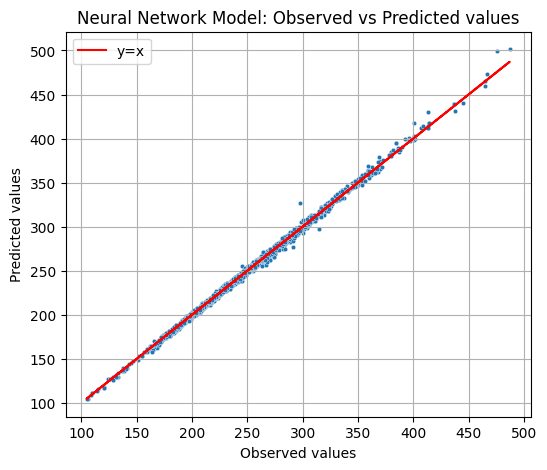

In [54]:
# Test the model on the test dataset------------------------   
# Using MSE as the evaluation metrics: Mean Squared Error, R2, MAE, MAPE
nn_model.eval()

# Get the prediction and true values
nn_test_true = []
nn_test_pred = []

val_loss = 0
with torch.no_grad():
    for X_batch, y_batch in test_Loader:

        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        y_pred = nn_model(X_batch)
        loss = criterion(y_pred, y_batch)
        val_loss += loss.item()

        nn_test_true.append(y_batch.cpu().detach().numpy())     # true value
        nn_test_pred.append(y_pred.cpu().detach().numpy())      # predicted value

# concatenate the true and predicted values
nn_test_true = np.concatenate(nn_test_true, axis=0).flatten()
nn_test_pred = np.concatenate(nn_test_pred, axis=0).flatten()

nn_test_r2 = r2_score(nn_test_pred, nn_test_true)
nn_test_mse = mean_squared_error(nn_test_pred, nn_test_true)
nn_test_mae = mean_absolute_error(nn_test_pred, nn_test_true)
nn_test_mape = mean_absolute_percentage_error(nn_test_pred, nn_test_true)

# Output
print(f'Neural Network Model:')
print(f"    Test Dataset MSE: {nn_test_mse:.4f}")
print(f"    Test Dataset R2: {nn_test_r2:.4f}")
print(f"    Test Dataset MAE: {nn_test_mae:.4f}")
print(f"    Test Dataset MAPE: {nn_test_mape:.4f}")

# Using plot
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
plot_pred_true(nn_test_true, nn_test_pred, ax)
plt.title('Neural Network Model: Observed vs Predicted values')

In [55]:
print(f"Test Dataset MSE: {nn_test_mse:.4f}")
print(f"Validation Dataset MSE: {np.mean(nn_k_fold_mse):.4f}")

Test Dataset MSE: 8.5209
Validation Dataset MSE: 8.2620


### 3.1.6 Save the NN Model Performance

Output of Best NN Model

- Output will include two types of data: Validation values, and Test Values, and combine those into one dataframe.

- Validation RSE:  1 x 20    Test RSE: 1 x 1

- Validation R2:   1 x 20    Test R2:  1 x 1

- Validation MAE:  1 x 20    Test MAE:  1 x 1

- Validation MAPE: 1 x 20    Test MAPE:  1 x 1

- So the output dataframe should include:

    - **4 rows**: RSE, R2, MAE and MAPE 
    
    - **21 cols**:  first 20 as validation metrics, with the last one being test metric

In [56]:
# Save the output of Best NN Model 
nn_metrics = pd.DataFrame([nn_k_fold_mse, nn_k_fold_R2, nn_k_fold_mae, nn_k_fold_mape])

# Add Test results
nn_metrics["Test_results"] = [nn_test_mse, nn_test_r2, nn_test_mae, nn_test_mape]


In [57]:
nn_metrics.columns = [f"fold_{i+1}" for i in range(20)] + ["Test"]
nn_metrics.index = ['MSE', 'R2', 'MAE', 'MAPE']


In [58]:
nn_metrics

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10,...,fold_12,fold_13,fold_14,fold_15,fold_16,fold_17,fold_18,fold_19,fold_20,Test
MSE,6.113358,7.313945,9.638522,8.677197,7.945219,7.501666,8.444725,7.785693,5.788854,21.090017,...,7.153397,6.624498,7.012626,8.323240,6.451344,8.504441,7.060046,7.443864,6.125840,8.520922
R2,0.998153,0.998061,0.997622,0.997541,0.997494,0.997941,0.997580,0.997420,0.998318,0.994024,...,0.997937,0.997960,0.997440,0.997560,0.998096,0.997403,0.997962,0.997540,0.998298,0.997588
MAE,1.983023,2.105791,2.410057,2.394346,2.208756,2.174423,2.315574,2.165404,1.971961,2.192429,...,2.214294,1.991784,2.153582,2.376910,2.093174,2.173668,2.091307,2.041270,1.974809,2.179332
MAPE,0.008238,0.008441,0.009456,0.009464,0.008862,0.008723,0.009460,0.008676,0.008045,0.009785,...,0.008813,0.008238,0.008685,0.009314,0.008459,0.008837,0.008293,0.008268,0.007799,0.008773


In [59]:
nn_test_pred_df = pd.DataFrame(nn_test_pred, columns=["y"])
nn_test_pred_df.to_csv("Workstream_1_ML_models/nn_test_pred.csv", index=False)  

In [60]:
nn_metrics.to_csv("Best_NN_Model_performance.csv", index=True)